In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# tạo file kaggle.json
import json

data = {
    "username": "camhuy",   # đúng với username trên Kaggle
    "key": "KGAT_fd3cdad8ef19be80b840a5e6bdfdc3b5"  # dán API token vào đây
}

with open("kaggle.json", "w") as f:
    json.dump(data, f)

print("Đã tạo file kaggle.json đúng chuẩn!")

Đã tạo file kaggle.json đúng chuẩn!


In [37]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [38]:
!kaggle datasets download -d jessicali9530/celeba-dataset -p /content/celeba
!unzip -q /content/celeba/celeba-dataset.zip -d /content/celeba

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/celeba/img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [39]:
from google.colab import files
uploaded = files.upload()

In [40]:
!mv /content/identity_CelebA.txt /content/celeba/

mv: cannot stat '/content/identity_CelebA.txt': No such file or directory


In [41]:
import os

OUTPUT = "/content/celeba_by_id"
os.makedirs(OUTPUT, exist_ok=True)

In [42]:
import shutil
from tqdm import tqdm
# Load file ID
import pandas as pd

id_file = "/content/celeba/identity_CelebA.txt"

identity = pd.read_csv(id_file,
                       sep=" ",
                       header=None,
                       names=["image", "id"])

identity.head()

IMG_DIR = "/content/celeba/img_align_celeba/img_align_celeba/"

for _, row in tqdm(identity.iterrows(), total=len(identity)):
    img_file = row['image']
    pid = str(row['id'])   # person ID

    # tạo folder theo ID
    dst_dir = f"{OUTPUT}/{pid}"
    os.makedirs(dst_dir, exist_ok=True)

    # copy ảnh vào thư mục ID tương ứng
    src_path = f"{IMG_DIR}/{img_file}"
    dst_path = f"{dst_dir}/{img_file}"

    shutil.copy(src_path, dst_path)

100%|██████████| 202599/202599 [01:26<00:00, 2330.70it/s]


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

DATA_PATH = Path('/content/celeba')

## 1. Load dữ liệu metadata gốc

In [44]:
identity_df = pd.read_csv(DATA_PATH / 'identity_CelebA.txt', sep=' ', header=None, names=['image_id', 'identity'])
attr_df = pd.read_csv(DATA_PATH / 'list_attr_celeba.csv')
partition_df = pd.read_csv(DATA_PATH / 'list_eval_partition.csv')
bbox_df = pd.read_csv(DATA_PATH / 'list_bbox_celeba.csv')
landmarks_df = pd.read_csv(DATA_PATH / 'list_landmarks_align_celeba.csv')

print("="*60)
print("THONG TIN TONG QUAN VE BO DU LIEU CELEBA")
print("="*60)
print(f"\nTong so anh: {len(identity_df):,}")
print(f"So luong danh tinh (identities): {identity_df['identity'].nunique():,}")
print(f"So thuoc tinh khuon mat: {len(attr_df.columns) - 1}")

print("\n" + "-"*40)
print("Kich thuoc cac file metadata:")
print("-"*40)
for name, df in [('Identity', identity_df), ('Attributes', attr_df),
                  ('Partition', partition_df), ('Bounding Box', bbox_df), ('Landmarks', landmarks_df)]:
    print(f"{name:15}: {df.shape}")

THONG TIN TONG QUAN VE BO DU LIEU CELEBA

Tong so anh: 202,599
So luong danh tinh (identities): 10,177
So thuoc tinh khuon mat: 40

----------------------------------------
Kich thuoc cac file metadata:
----------------------------------------
Identity       : (202599, 2)
Attributes     : (202599, 41)
Partition      : (202599, 2)
Bounding Box   : (202599, 5)
Landmarks      : (202599, 11)


## 2. Phân tích phân bố danh tính (Identity Distribution)

In [45]:
identity_counts = identity_df['identity'].value_counts()

print("="*60)
print("PHAN TICH PHAN BO DANH TINH")
print("="*60)
print(f"\nThong ke so anh moi danh tinh:")
print(identity_counts.describe())

print(f"\n" + "-"*40)
print(f"Danh tinh co nhieu anh nhat: ID {identity_counts.idxmax()} voi {identity_counts.max()} anh")
print(f"Danh tinh co it anh nhat: ID {identity_counts.idxmin()} voi {identity_counts.min()} anh")
print(f"So anh trung binh moi danh tinh: {identity_counts.mean():.2f}")
print(f"Do lech chuan: {identity_counts.std():.2f}")
print(f"Median: {identity_counts.median():.0f}")

print(f"\n" + "-"*40)
print("Phan bo so luong anh theo danh tinh:")

# Get the maximum identity count
max_identity_count = identity_counts.max()

# Define base bins and labels
base_bins = [1, 5, 10, 20, 30]
# Extend base_labels to match the length of base_bins
base_labels = ['1-4', '5-9', '10-19', '20-29', '30+'] # Added '30+' as a placeholder

# Dynamically construct bins and labels to ensure monotonicity and cover the max value
bins = []
labels = []

# Ensure the loop does not go out of bounds for base_labels
for i in range(min(len(base_bins), len(base_labels))):
    if base_bins[i] <= max_identity_count:
        bins.append(base_bins[i])
        labels.append(base_labels[i])
    else:
        break # Stop if current base bin is already greater than max_identity_count

# Ensure the last bin covers the maximum value
if not bins or max_identity_count + 1 > bins[-1]:
    # Append max_identity_count + 1 as the upper bound for the last bin
    bins.append(max_identity_count + 1)

    # Adjust the last label to reflect the actual max_identity_count
    if len(labels) > 0:
        # Assuming the last label is of the form 'X-Y' or 'X+'
        last_label_text = labels[-1]
        if '-' in last_label_text:
            last_label_start = int(last_label_text.split('-')[0])
        elif '+' in last_label_text:
            last_label_start = int(last_label_text.replace('+', ''))
        else:
            last_label_start = int(last_label_text) # Fallback if label is just a number

        labels[-1] = f"{last_label_start}-{max_identity_count}"
    else:
        # Handle case where max_identity_count is very small (e.g., 1-4) and no base labels were used
        labels.append(f"1-{max_identity_count}")

identity_bins = pd.cut(identity_counts, bins=bins, labels=labels, right=False)
bin_counts = identity_bins.value_counts().sort_index()
for label, count in bin_counts.items():
    pct = count / len(identity_counts) * 100
    print(f"  {label:8} anh: {count:5} danh tinh ({pct:.1f}%)")

PHAN TICH PHAN BO DANH TINH

Thong ke so anh moi danh tinh:
count    10177.000000
mean        19.907537
std          8.925916
min          1.000000
25%         13.000000
50%         21.000000
75%         29.000000
max         35.000000
Name: count, dtype: float64

----------------------------------------
Danh tinh co nhieu anh nhat: ID 3782 voi 35 anh
Danh tinh co it anh nhat: ID 4548 voi 1 anh
So anh trung binh moi danh tinh: 19.91
Do lech chuan: 8.93
Median: 21

----------------------------------------
Phan bo so luong anh theo danh tinh:
  1-4      anh:   834 danh tinh (8.2%)
  5-9      anh:   974 danh tinh (9.6%)
  10-19    anh:  2021 danh tinh (19.9%)
  20-29    anh:  3988 danh tinh (39.2%)
  30-35    anh:  2360 danh tinh (23.2%)


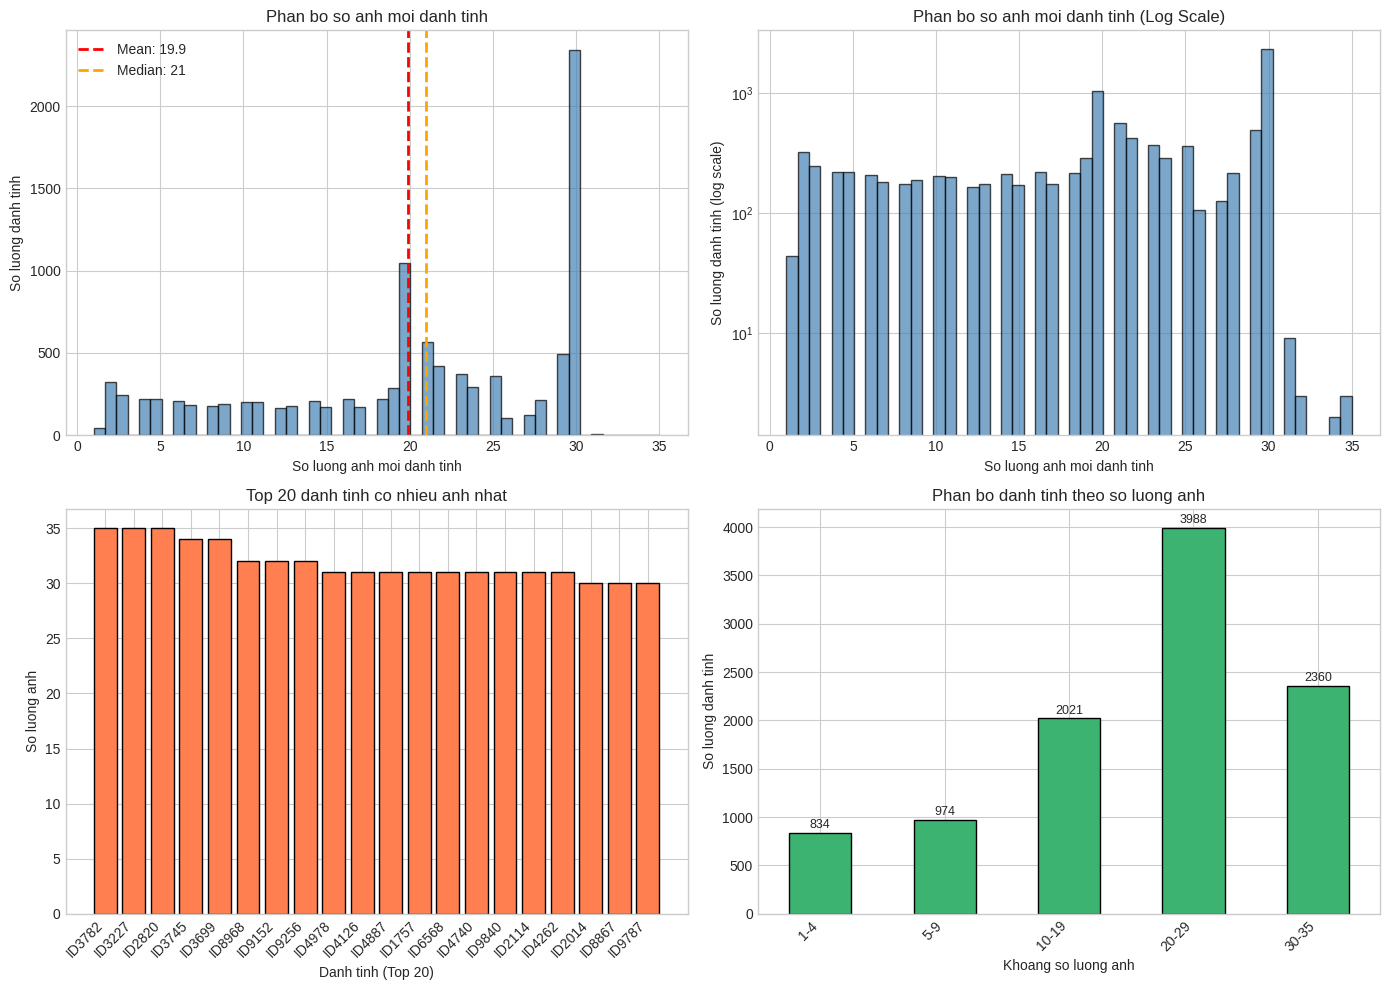

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
ax1.hist(identity_counts.values, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(identity_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {identity_counts.mean():.1f}')
ax1.axvline(identity_counts.median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {identity_counts.median():.0f}')
ax1.set_xlabel('So luong anh moi danh tinh')
ax1.set_ylabel('So luong danh tinh')
ax1.set_title('Phan bo so anh moi danh tinh')
ax1.legend()

ax2 = axes[0, 1]
ax2.hist(identity_counts.values, bins=50, edgecolor='black', alpha=0.7, color='steelblue', log=True)
ax2.set_xlabel('So luong anh moi danh tinh')
ax2.set_ylabel('So luong danh tinh (log scale)')
ax2.set_title('Phan bo so anh moi danh tinh (Log Scale)')

ax3 = axes[1, 0]
top_20 = identity_counts.head(20)
bars = ax3.bar(range(len(top_20)), top_20.values, color='coral', edgecolor='black')
ax3.set_xlabel('Danh tinh (Top 20)')
ax3.set_ylabel('So luong anh')
ax3.set_title('Top 20 danh tinh co nhieu anh nhat')
ax3.set_xticks(range(len(top_20)))
ax3.set_xticklabels([f'ID{i}' for i in top_20.index], rotation=45, ha='right')

ax4 = axes[1, 1]
bin_counts.plot(kind='bar', ax=ax4, color='mediumseagreen', edgecolor='black')
ax4.set_xlabel('Khoang so luong anh')
ax4.set_ylabel('So luong danh tinh')
ax4.set_title('Phan bo danh tinh theo so luong anh')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
for i, v in enumerate(bin_counts.values):
    ax4.text(i, v + 50, f'{v}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## 3. Phan tich su mat can bang du lieu (Class Imbalance Analysis)

In [47]:
print("="*60)
print("PHAN TICH SU MAT CAN BANG DU LIEU")
print("="*60)

imbalance_ratio = identity_counts.max() / identity_counts.min()
print(f"\nTy le mat can bang (max/min): {imbalance_ratio:.2f}x")

sorted_counts = identity_counts.sort_values(ascending=False)
cumsum = sorted_counts.cumsum()
total = sorted_counts.sum()

top_10_pct = (sorted_counts.head(int(len(sorted_counts)*0.1)).sum() / total) * 100
top_20_pct = (sorted_counts.head(int(len(sorted_counts)*0.2)).sum() / total) * 100
bottom_50_pct = (sorted_counts.tail(int(len(sorted_counts)*0.5)).sum() / total) * 100

print(f"\n" + "-"*40)
print("Phan tich ty le anh theo danh tinh:")
print(f"  Top 10% danh tinh chiem: {top_10_pct:.1f}% tong so anh")
print(f"  Top 20% danh tinh chiem: {top_20_pct:.1f}% tong so anh")
print(f"  Bottom 50% danh tinh chi chiem: {bottom_50_pct:.1f}% tong so anh")

gini = (2 * np.sum(np.arange(1, len(sorted_counts)+1) * sorted_counts.values) / (len(sorted_counts) * sorted_counts.sum())) - (len(sorted_counts)+1)/len(sorted_counts)
print(f"\n" + "-"*40)
print(f"He so Gini (do mat can bang): {gini:.4f}")
print("  (0 = can bang hoan hao, 1 = mat can bang hoan toan)")

percentiles = [10, 25, 50, 75, 90, 95, 99]
print(f"\n" + "-"*40)
print("Phan vi so luong anh moi danh tinh:")
for p in percentiles:
    val = np.percentile(identity_counts, p)
    print(f"  P{p:2}: {val:.0f} anh")

PHAN TICH SU MAT CAN BANG DU LIEU

Ty le mat can bang (max/min): 35.00x

----------------------------------------
Phan tich ty le anh theo danh tinh:
  Top 10% danh tinh chiem: 15.1% tong so anh
  Top 20% danh tinh chiem: 30.2% tong so anh
  Bottom 50% danh tinh chi chiem: 31.7% tong so anh

----------------------------------------
He so Gini (do mat can bang): -0.2515
  (0 = can bang hoan hao, 1 = mat can bang hoan toan)

----------------------------------------
Phan vi so luong anh moi danh tinh:
  P10: 5 anh
  P25: 13 anh
  P50: 21 anh
  P75: 29 anh
  P90: 30 anh
  P95: 30 anh
  P99: 30 anh


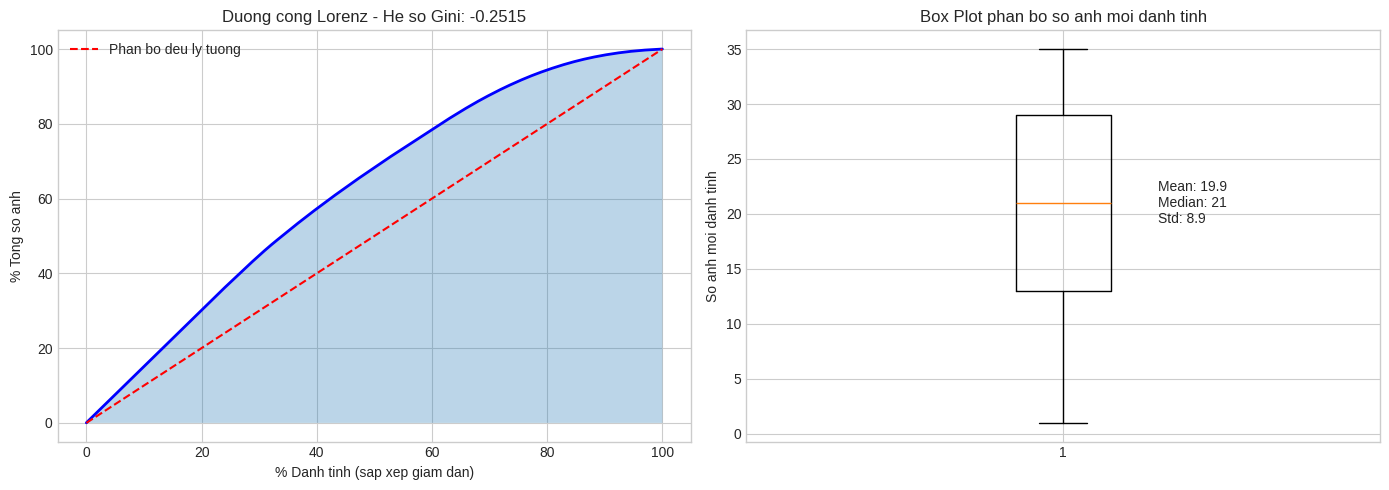

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
sorted_idx = np.argsort(identity_counts.values)[::-1]
cumsum_pct = np.cumsum(identity_counts.values[sorted_idx]) / total * 100
ax1.plot(np.arange(len(cumsum_pct)) / len(cumsum_pct) * 100, cumsum_pct, 'b-', linewidth=2)
ax1.plot([0, 100], [0, 100], 'r--', label='Phan bo deu ly tuong')
ax1.fill_between(np.arange(len(cumsum_pct)) / len(cumsum_pct) * 100, cumsum_pct, alpha=0.3)
ax1.set_xlabel('% Danh tinh (sap xep giam dan)')
ax1.set_ylabel('% Tong so anh')
ax1.set_title(f'Duong cong Lorenz - He so Gini: {gini:.4f}')
ax1.legend()
ax1.grid(True)

ax2 = axes[1]
ax2.boxplot(identity_counts.values, vert=True)
ax2.set_ylabel('So anh moi danh tinh')
ax2.set_title('Box Plot phan bo so anh moi danh tinh')
stats_text = f"Mean: {identity_counts.mean():.1f}\nMedian: {identity_counts.median():.0f}\nStd: {identity_counts.std():.1f}"
ax2.text(1.15, identity_counts.median(), stats_text, fontsize=10, verticalalignment='center')

plt.tight_layout()
plt.show()

## 4. Phan tich phan chia Train/Val/Test (Partition Analysis)

In [49]:
merged_df = identity_df.merge(partition_df, on='image_id')
partition_names = {0: 'Train', 1: 'Validation', 2: 'Test'}
merged_df['partition_name'] = merged_df['partition'].map(partition_names)

print("="*60)
print("PHAN TICH PHAN CHIA TRAIN/VAL/TEST")
print("="*60)

partition_counts = merged_df['partition_name'].value_counts()
print("\nSo luong anh theo partition:")
for name in ['Train', 'Validation', 'Test']:
    count = partition_counts.get(name, 0)
    pct = count / len(merged_df) * 100
    print(f"  {name:12}: {count:,} anh ({pct:.1f}%)")

print("\n" + "-"*40)
print("So luong danh tinh xuat hien trong moi partition:")
for partition in [0, 1, 2]:
    subset = merged_df[merged_df['partition'] == partition]
    n_identities = subset['identity'].nunique()
    print(f"  {partition_names[partition]:12}: {n_identities:,} danh tinh")

print("\n" + "-"*40)
print("Kiem tra su chong cheo danh tinh giua cac partition:")
train_ids = set(merged_df[merged_df['partition'] == 0]['identity'].unique())
val_ids = set(merged_df[merged_df['partition'] == 1]['identity'].unique())
test_ids = set(merged_df[merged_df['partition'] == 2]['identity'].unique())

train_val_overlap = train_ids & val_ids
train_test_overlap = train_ids & test_ids
val_test_overlap = val_ids & test_ids
all_overlap = train_ids & val_ids & test_ids

print(f"  Train & Val: {len(train_val_overlap):,} danh tinh chung")
print(f"  Train & Test: {len(train_test_overlap):,} danh tinh chung")
print(f"  Val & Test: {len(val_test_overlap):,} danh tinh chung")
print(f"  Train & Val & Test: {len(all_overlap):,} danh tinh chung")

PHAN TICH PHAN CHIA TRAIN/VAL/TEST

So luong anh theo partition:
  Train       : 162,770 anh (80.3%)
  Validation  : 19,867 anh (9.8%)
  Test        : 19,962 anh (9.9%)

----------------------------------------
So luong danh tinh xuat hien trong moi partition:
  Train       : 8,192 danh tinh
  Validation  : 985 danh tinh
  Test        : 1,000 danh tinh

----------------------------------------
Kiem tra su chong cheo danh tinh giua cac partition:
  Train & Val: 0 danh tinh chung
  Train & Test: 0 danh tinh chung
  Val & Test: 0 danh tinh chung
  Train & Val & Test: 0 danh tinh chung


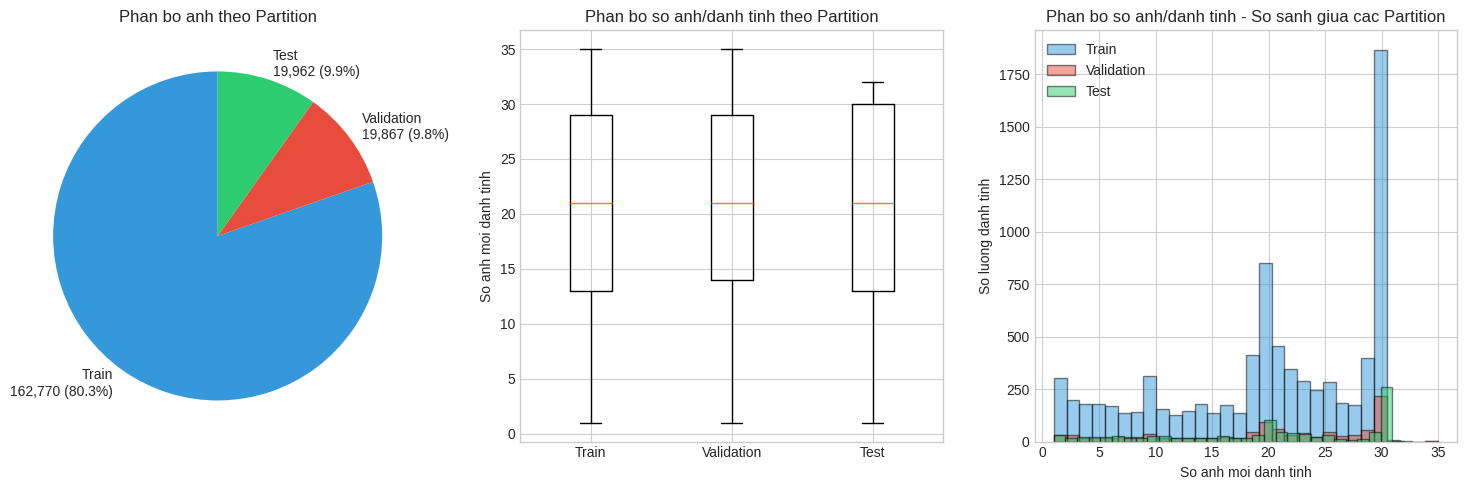

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax1 = axes[0]
colors = ['#3498db', '#e74c3c', '#2ecc71']
sizes = [partition_counts.get(name, 0) for name in ['Train', 'Validation', 'Test']]
labels = [f'{name}\n{count:,} ({count/sum(sizes)*100:.1f}%)'
          for name, count in zip(['Train', 'Validation', 'Test'], sizes)]
ax1.pie(sizes, labels=labels, colors=colors, autopct='', startangle=90)
ax1.set_title('Phan bo anh theo Partition')

ax2 = axes[1]
partition_identity_counts = []
for partition in [0, 1, 2]:
    subset = merged_df[merged_df['partition'] == partition]
    counts = subset['identity'].value_counts()
    partition_identity_counts.append(counts)

ax2.boxplot([counts.values for counts in partition_identity_counts],
            labels=['Train', 'Validation', 'Test'])
ax2.set_ylabel('So anh moi danh tinh')
ax2.set_title('Phan bo so anh/danh tinh theo Partition')

ax3 = axes[2]
for i, (partition, name, color) in enumerate([(0, 'Train', '#3498db'),
                                               (1, 'Validation', '#e74c3c'),
                                               (2, 'Test', '#2ecc71')]):
    counts = partition_identity_counts[i]
    ax3.hist(counts.values, bins=30, alpha=0.5, label=name, color=color, edgecolor='black')
ax3.set_xlabel('So anh moi danh tinh')
ax3.set_ylabel('So luong danh tinh')
ax3.set_title('Phan bo so anh/danh tinh - So sanh giua cac Partition')
ax3.legend()

plt.tight_layout()
plt.show()

## 5. Phan tich thuoc tinh khuon mat (Face Attributes Analysis)

In [51]:
print("="*60)
print("PHAN TICH THUOC TINH KHUON MAT")
print("="*60)

attr_columns = [col for col in attr_df.columns if col != 'image_id']
print(f"\nTong so thuoc tinh: {len(attr_columns)}")
print(f"Danh sach thuoc tinh:\n{attr_columns}")

attr_stats = []
for col in attr_columns:
    positive = (attr_df[col] == 1).sum()
    negative = (attr_df[col] == -1).sum()
    ratio = positive / len(attr_df) * 100
    attr_stats.append({
        'attribute': col,
        'positive': positive,
        'negative': negative,
        'positive_ratio': ratio
    })

attr_stats_df = pd.DataFrame(attr_stats).sort_values('positive_ratio', ascending=False)

print("\n" + "-"*40)
print("Top 10 thuoc tinh pho bien nhat:")
for _, row in attr_stats_df.head(10).iterrows():
    print(f"  {row['attribute']:25}: {row['positive_ratio']:.1f}%")

print("\n" + "-"*40)
print("Top 10 thuoc tinh hiem nhat:")
for _, row in attr_stats_df.tail(10).iterrows():
    print(f"  {row['attribute']:25}: {row['positive_ratio']:.1f}%")

PHAN TICH THUOC TINH KHUON MAT

Tong so thuoc tinh: 40
Danh sach thuoc tinh:
['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']

----------------------------------------
Top 10 thuoc tinh pho bien nhat:
  No_Beard                 : 83.5%
  Young                    : 77.4%
  Attractive               : 51.3%
  Mouth_Slightly_Open      : 48.3%
  Smiling                  : 48.2%
  Wearing_Lipstick         : 47.2%
  High_Cheekbones          : 45.5%
  Male            

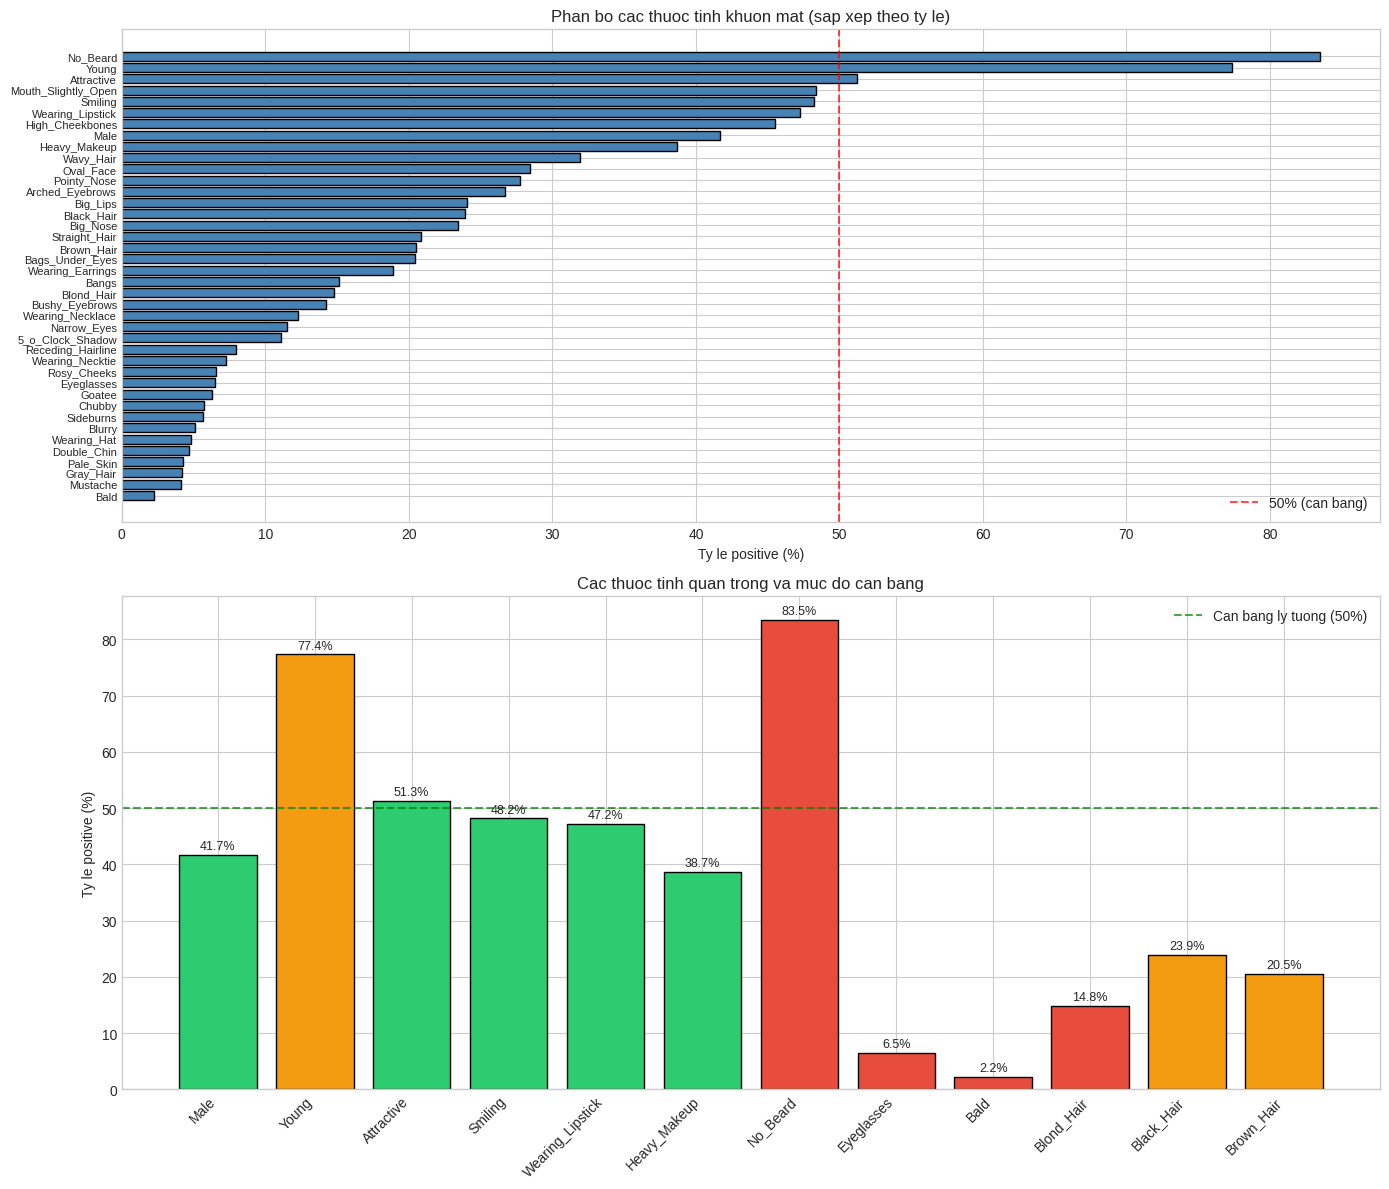

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

ax1 = axes[0]
sorted_attrs = attr_stats_df.sort_values('positive_ratio', ascending=True)
bars = ax1.barh(range(len(sorted_attrs)), sorted_attrs['positive_ratio'].values, color='steelblue', edgecolor='black')
ax1.set_yticks(range(len(sorted_attrs)))
ax1.set_yticklabels(sorted_attrs['attribute'].values, fontsize=8)
ax1.set_xlabel('Ty le positive (%)')
ax1.set_title('Phan bo cac thuoc tinh khuon mat (sap xep theo ty le)')
ax1.axvline(50, color='red', linestyle='--', alpha=0.7, label='50% (can bang)')
ax1.legend()

ax2 = axes[1]
male_ratio = attr_stats_df[attr_stats_df['attribute'] == 'Male']['positive_ratio'].values[0]
young_ratio = attr_stats_df[attr_stats_df['attribute'] == 'Young']['positive_ratio'].values[0]
attractive_ratio = attr_stats_df[attr_stats_df['attribute'] == 'Attractive']['positive_ratio'].values[0]

key_attrs = ['Male', 'Young', 'Attractive', 'Smiling', 'Wearing_Lipstick', 'Heavy_Makeup',
             'No_Beard', 'Eyeglasses', 'Bald', 'Blond_Hair', 'Black_Hair', 'Brown_Hair']
key_ratios = [attr_stats_df[attr_stats_df['attribute'] == attr]['positive_ratio'].values[0] for attr in key_attrs]

colors = ['#e74c3c' if r < 20 or r > 80 else '#f39c12' if r < 35 or r > 65 else '#2ecc71' for r in key_ratios]
bars = ax2.bar(range(len(key_attrs)), key_ratios, color=colors, edgecolor='black')
ax2.set_xticks(range(len(key_attrs)))
ax2.set_xticklabels(key_attrs, rotation=45, ha='right')
ax2.set_ylabel('Ty le positive (%)')
ax2.set_title('Cac thuoc tinh quan trong va muc do can bang')
ax2.axhline(50, color='green', linestyle='--', alpha=0.7, label='Can bang ly tuong (50%)')
ax2.legend()

for i, (ratio, bar) in enumerate(zip(key_ratios, bars)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{ratio:.1f}%',
             ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## 6. Phan tich Bounding Box va Landmarks

In [53]:
print("="*60)
print("PHAN TICH BOUNDING BOX")
print("="*60)

bbox_df['area'] = bbox_df['width'] * bbox_df['height']
bbox_df['aspect_ratio'] = bbox_df['width'] / bbox_df['height']

print("\nThong ke kich thuoc Bounding Box:")
print(bbox_df[['x_1', 'y_1', 'width', 'height', 'area', 'aspect_ratio']].describe())

print("\n" + "-"*40)
print("Kiem tra gia tri bat thuong:")
print(f"  So bbox co width <= 0: {(bbox_df['width'] <= 0).sum()}")
print(f"  So bbox co height <= 0: {(bbox_df['height'] <= 0).sum()}")
print(f"  So bbox co area < 100: {(bbox_df['area'] < 100).sum()}")

print("\n" + "="*60)
print("PHAN TICH LANDMARKS")
print("="*60)

landmark_cols = [col for col in landmarks_df.columns if col != 'image_id']
print("\nThong ke Landmarks:")
print(landmarks_df[landmark_cols].describe())

landmarks_df['eye_distance'] = np.sqrt(
    (landmarks_df['righteye_x'] - landmarks_df['lefteye_x'])**2 +
    (landmarks_df['righteye_y'] - landmarks_df['lefteye_y'])**2
)
landmarks_df['mouth_width'] = np.sqrt(
    (landmarks_df['rightmouth_x'] - landmarks_df['leftmouth_x'])**2 +
    (landmarks_df['rightmouth_y'] - landmarks_df['leftmouth_y'])**2
)

print("\n" + "-"*40)
print("Thong ke khoang cach mat va mieng:")
print(f"  Khoang cach mat trung binh: {landmarks_df['eye_distance'].mean():.2f} px")
print(f"  Do rong mieng trung binh: {landmarks_df['mouth_width'].mean():.2f} px")

PHAN TICH BOUNDING BOX

Thong ke kich thuoc Bounding Box:
                 x_1            y_1          width         height  \
count  202599.000000  202599.000000  202599.000000  202599.000000   
mean      156.764564      84.335505     194.754061     268.922329   
std       164.518135      76.067284     141.770066     195.664936   
min         1.000000       0.000000       0.000000       0.000000   
25%        69.000000      44.000000     120.000000     166.000000   
50%       110.000000      68.000000     164.000000     227.000000   
75%       181.000000      98.000000     221.000000     306.000000   
max      3840.000000    1858.000000    3827.000000    5299.000000   

               area   aspect_ratio  
count  2.025990e+05  202598.000000  
mean   8.007989e+04       0.724000  
std    2.232288e+05       0.021138  
min    0.000000e+00       0.350453  
25%    1.992000e+04       0.721925  
50%    3.722800e+04       0.722222  
75%    6.762600e+04       0.722543  
max    2.027927e+07     

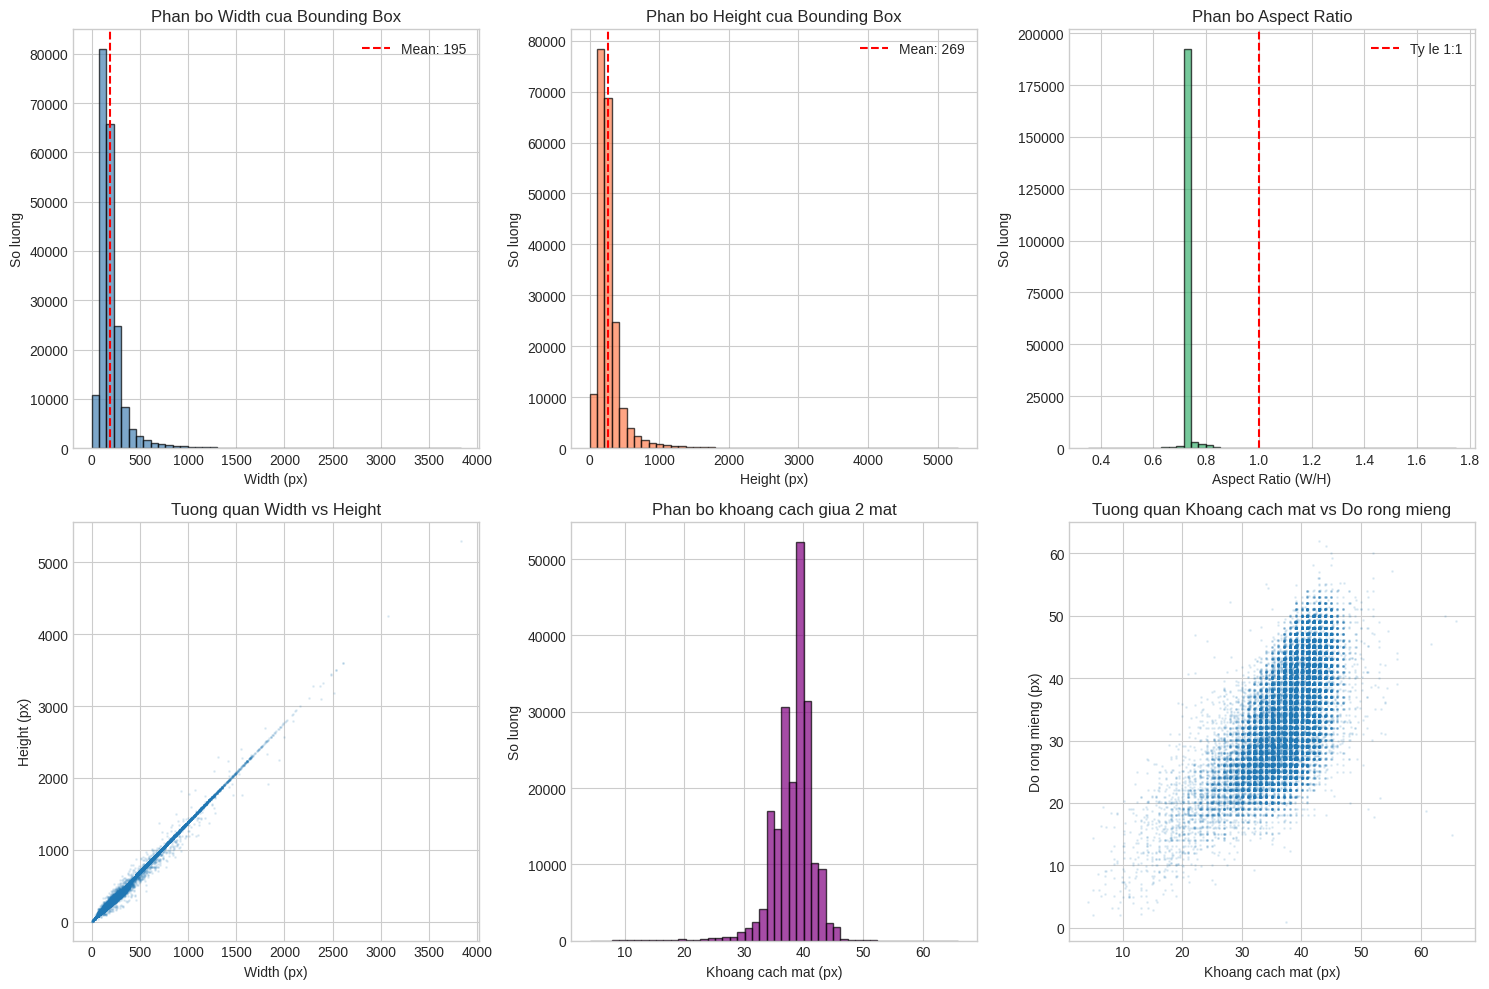

In [54]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

ax1 = axes[0, 0]
ax1.hist(bbox_df['width'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('Width (px)')
ax1.set_ylabel('So luong')
ax1.set_title('Phan bo Width cua Bounding Box')
ax1.axvline(bbox_df['width'].mean(), color='red', linestyle='--', label=f"Mean: {bbox_df['width'].mean():.0f}")
ax1.legend()

ax2 = axes[0, 1]
ax2.hist(bbox_df['height'], bins=50, alpha=0.7, color='coral', edgecolor='black')
ax2.set_xlabel('Height (px)')
ax2.set_ylabel('So luong')
ax2.set_title('Phan bo Height cua Bounding Box')
ax2.axvline(bbox_df['height'].mean(), color='red', linestyle='--', label=f"Mean: {bbox_df['height'].mean():.0f}")
ax2.legend()

ax3 = axes[0, 2]
ax3.hist(bbox_df['aspect_ratio'], bins=50, alpha=0.7, color='mediumseagreen', edgecolor='black')
ax3.set_xlabel('Aspect Ratio (W/H)')
ax3.set_ylabel('So luong')
ax3.set_title('Phan bo Aspect Ratio')
ax3.axvline(1.0, color='red', linestyle='--', label='Ty le 1:1')
ax3.legend()

ax4 = axes[1, 0]
ax4.scatter(bbox_df['width'], bbox_df['height'], alpha=0.1, s=1)
ax4.set_xlabel('Width (px)')
ax4.set_ylabel('Height (px)')
ax4.set_title('Tuong quan Width vs Height')

ax5 = axes[1, 1]
ax5.hist(landmarks_df['eye_distance'], bins=50, alpha=0.7, color='purple', edgecolor='black')
ax5.set_xlabel('Khoang cach mat (px)')
ax5.set_ylabel('So luong')
ax5.set_title('Phan bo khoang cach giua 2 mat')

ax6 = axes[1, 2]
ax6.scatter(landmarks_df['eye_distance'], landmarks_df['mouth_width'], alpha=0.1, s=1)
ax6.set_xlabel('Khoang cach mat (px)')
ax6.set_ylabel('Do rong mieng (px)')
ax6.set_title('Tuong quan Khoang cach mat vs Do rong mieng')

plt.tight_layout()
plt.show()

## 7. Phan tich thuoc tinh theo danh tinh va gioi tinh

In [55]:
full_df = identity_df.merge(attr_df, on='image_id').merge(partition_df, on='image_id')

print("="*60)
print("PHAN TICH THUOC TINH THEO GIOI TINH")
print("="*60)

male_count = (full_df['Male'] == 1).sum()
female_count = (full_df['Male'] == -1).sum()
print(f"\nPhan bo gioi tinh:")
print(f"  Nam: {male_count:,} anh ({male_count/len(full_df)*100:.1f}%)")
print(f"  Nu: {female_count:,} anh ({female_count/len(full_df)*100:.1f}%)")

identity_gender = full_df.groupby('identity')['Male'].apply(lambda x: (x == 1).mean())
male_identities = (identity_gender > 0.5).sum()
female_identities = (identity_gender <= 0.5).sum()

print(f"\nPhan bo danh tinh theo gioi tinh:")
print(f"  Danh tinh nam: {male_identities:,} ({male_identities/len(identity_gender)*100:.1f}%)")
print(f"  Danh tinh nu: {female_identities:,} ({female_identities/len(identity_gender)*100:.1f}%)")

print("\n" + "-"*40)
print("So luong anh trung binh theo gioi tinh:")
male_df = full_df[full_df['Male'] == 1]
female_df = full_df[full_df['Male'] == -1]
male_img_per_id = male_df.groupby('identity').size()
female_img_per_id = female_df.groupby('identity').size()
print(f"  Nam: {male_img_per_id.mean():.2f} anh/danh tinh")
print(f"  Nu: {female_img_per_id.mean():.2f} anh/danh tinh")

PHAN TICH THUOC TINH THEO GIOI TINH

Phan bo gioi tinh:
  Nam: 84,434 anh (41.7%)
  Nu: 118,165 anh (58.3%)

Phan bo danh tinh theo gioi tinh:
  Danh tinh nam: 4,540 (44.6%)
  Danh tinh nu: 5,637 (55.4%)

----------------------------------------
So luong anh trung binh theo gioi tinh:
  Nam: 16.78 anh/danh tinh
  Nu: 20.51 anh/danh tinh


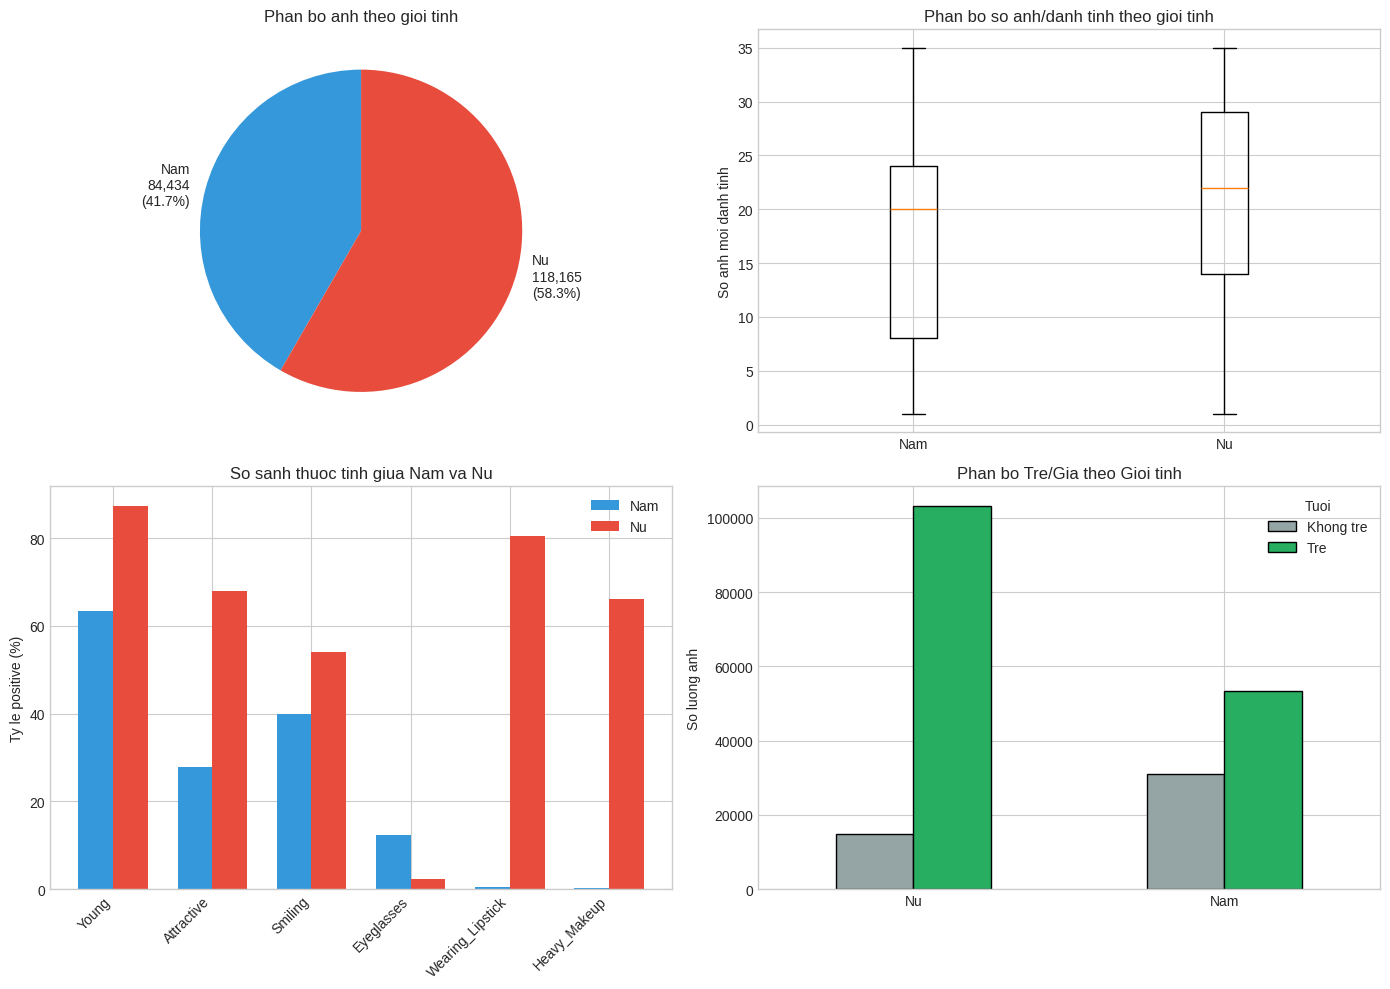

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
sizes = [male_count, female_count]
labels = [f'Nam\n{male_count:,}\n({male_count/len(full_df)*100:.1f}%)',
          f'Nu\n{female_count:,}\n({female_count/len(full_df)*100:.1f}%)']
ax1.pie(sizes, labels=labels, colors=['#3498db', '#e74c3c'], autopct='', startangle=90)
ax1.set_title('Phan bo anh theo gioi tinh')

ax2 = axes[0, 1]
ax2.boxplot([male_img_per_id.values, female_img_per_id.values], labels=['Nam', 'Nu'])
ax2.set_ylabel('So anh moi danh tinh')
ax2.set_title('Phan bo so anh/danh tinh theo gioi tinh')

ax3 = axes[1, 0]
selected_attrs = ['Young', 'Attractive', 'Smiling', 'Eyeglasses', 'Wearing_Lipstick', 'Heavy_Makeup']
male_attr_rates = []
female_attr_rates = []
for attr in selected_attrs:
    male_rate = (male_df[attr] == 1).mean() * 100
    female_rate = (female_df[attr] == 1).mean() * 100
    male_attr_rates.append(male_rate)
    female_attr_rates.append(female_rate)

x = np.arange(len(selected_attrs))
width = 0.35
bars1 = ax3.bar(x - width/2, male_attr_rates, width, label='Nam', color='#3498db')
bars2 = ax3.bar(x + width/2, female_attr_rates, width, label='Nu', color='#e74c3c')
ax3.set_ylabel('Ty le positive (%)')
ax3.set_title('So sanh thuoc tinh giua Nam va Nu')
ax3.set_xticks(x)
ax3.set_xticklabels(selected_attrs, rotation=45, ha='right')
ax3.legend()

ax4 = axes[1, 1]
young_old_counts = full_df.groupby(['Male', 'Young']).size().unstack(fill_value=0)
young_old_counts.index = ['Nu', 'Nam']
young_old_counts.columns = ['Khong tre', 'Tre']
young_old_counts.plot(kind='bar', ax=ax4, color=['#95a5a6', '#27ae60'], edgecolor='black')
ax4.set_ylabel('So luong anh')
ax4.set_title('Phan bo Tre/Gia theo Gioi tinh')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)
ax4.legend(title='Tuoi')

plt.tight_layout()
plt.show()

## 8. Tong ket va Khuyen nghi

In [57]:
print("="*70)
print("TONG KET PHAN TICH BO DU LIEU CELEBA")
print("="*70)

print("\n1. THONG TIN TONG QUAN:")
print(f"   - Tong so anh: {len(identity_df):,}")
print(f"   - So luong danh tinh: {identity_df['identity'].nunique():,}")
print(f"   - So thuoc tinh: {len(attr_columns)}")

print("\n2. VAN DE MAT CAN BANG DU LIEU:")
print(f"   - Ty le mat can bang (max/min): {imbalance_ratio:.2f}x")
print(f"   - He so Gini: {gini:.4f}")
print(f"   - Top 20% danh tinh chiem {top_20_pct:.1f}% tong so anh")
print(f"   - Bottom 50% danh tinh chi chiem {bottom_50_pct:.1f}% tong so anh")

print("\n3. PHAN BO GIOI TINH:")
print(f"   - Nam: {male_count:,} anh ({male_count/len(full_df)*100:.1f}%)")
print(f"   - Nu: {female_count:,} anh ({female_count/len(full_df)*100:.1f}%)")
print(f"   => Du lieu LECH ve phia nu")

print("\n4. DANH GIA:")
print("   [!] Du lieu CO MAT CAN BANG NGHIEM TRONG:")
print(f"       - Mot so danh tinh co {identity_counts.max()} anh")
print(f"       - Nhieu danh tinh chi co {identity_counts.min()} anh")
print("   [!] Phan bo gioi tinh khong deu (nhieu nu hon nam)")
print("   [!] Nhieu thuoc tinh rat lech (VD: No_Beard > 80%, Bald < 5%)")

print("\n5. KHUYEN NGHI:")
print("   - Su dung ky thuat sampling (oversampling/undersampling)")
print("   - Ap dung class weights trong ham loss")
print("   - Loc bo cac danh tinh co qua it anh (< 5-10 anh)")
print("   - Xem xet data augmentation cho cac class thieu")
print("   - Chia train/val/test dam bao moi danh tinh co du anh")

print("\n" + "="*70)

TONG KET PHAN TICH BO DU LIEU CELEBA

1. THONG TIN TONG QUAN:
   - Tong so anh: 202,599
   - So luong danh tinh: 10,177
   - So thuoc tinh: 40

2. VAN DE MAT CAN BANG DU LIEU:
   - Ty le mat can bang (max/min): 35.00x
   - He so Gini: -0.2515
   - Top 20% danh tinh chiem 30.2% tong so anh
   - Bottom 50% danh tinh chi chiem 31.7% tong so anh

3. PHAN BO GIOI TINH:
   - Nam: 84,434 anh (41.7%)
   - Nu: 118,165 anh (58.3%)
   => Du lieu LECH ve phia nu

4. DANH GIA:
   [!] Du lieu CO MAT CAN BANG NGHIEM TRONG:
       - Mot so danh tinh co 35 anh
       - Nhieu danh tinh chi co 1 anh
   [!] Phan bo gioi tinh khong deu (nhieu nu hon nam)
   [!] Nhieu thuoc tinh rat lech (VD: No_Beard > 80%, Bald < 5%)

5. KHUYEN NGHI:
   - Su dung ky thuat sampling (oversampling/undersampling)
   - Ap dung class weights trong ham loss
   - Loc bo cac danh tinh co qua it anh (< 5-10 anh)
   - Xem xet data augmentation cho cac class thieu
   - Chia train/val/test dam bao moi danh tinh co du anh



In [58]:
summary_data = {
    'Metric': [
        'Tong so anh',
        'So luong danh tinh',
        'So anh/danh tinh trung binh',
        'So anh/danh tinh max',
        'So anh/danh tinh min',
        'Ty le mat can bang',
        'He so Gini',
        'Ty le anh nam',
        'Ty le anh nu',
        'So danh tinh nam',
        'So danh tinh nu'
    ],
    'Gia tri': [
        f'{len(identity_df):,}',
        f'{identity_df["identity"].nunique():,}',
        f'{identity_counts.mean():.2f}',
        f'{identity_counts.max()}',
        f'{identity_counts.min()}',
        f'{imbalance_ratio:.2f}x',
        f'{gini:.4f}',
        f'{male_count/len(full_df)*100:.1f}%',
        f'{female_count/len(full_df)*100:.1f}%',
        f'{male_identities:,}',
        f'{female_identities:,}'
    ]
}
summary_df = pd.DataFrame(summary_data)
print("\nBANG TONG HOP THONG KE:")
print(summary_df.to_string(index=False))


BANG TONG HOP THONG KE:
                     Metric Gia tri
                Tong so anh 202,599
         So luong danh tinh  10,177
So anh/danh tinh trung binh   19.91
       So anh/danh tinh max      35
       So anh/danh tinh min       1
         Ty le mat can bang  35.00x
                 He so Gini -0.2515
              Ty le anh nam   41.7%
               Ty le anh nu   58.3%
           So danh tinh nam   4,540
            So danh tinh nu   5,637
